In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import RidgeCV
warnings.resetwarnings()

# Model prototyping

The goal of this notebook is to get a feel for the performance of the two different types of models to be trained.
Specifically, comparison will be made between a naive baseline model, a ridge regression model, and a convolutional neural network model. Because this notebook is simply prototyping, a very small subset of the available data will be used; a single 
feature's time series for a single country, the United States. This single feature is all that will be available to the CNN and Ridge regression models; because eventually the feature data used in the regression is much larger than that used in the CNN training, this might be an unfair comparison.

The main issue for using a very small subset of data is that I believe it will affect the CNN more than the regression, because
the small number of samples influences how well the specific architecture will perform. Regardless I will press on and continue this testing. 

Both will use mean squared error as their loss function, unfortunately this means that I have to use RidgeCV, which means I need to provide my own folds in order to respect time ordering.

Much like how in regression we want to include multiple days of information for prediction,  it may also be benefitial to convolve multiple frames together for the CNN?

In [2]:

def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_true, y_naive, y_predict, title='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    print(y_true.shape, y_naive.shape, y_predict.shape)
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None

# Copied from last capstone project. 
def classifier_analysis(clf, X_test, y_test, plot=True, metric='evs'):
    
    '''
        Predict using trained scikit-learn estimator and compute and plot various metrics:
        Prints 
        
        Parameters:
        
        X_test : ndarray or DataFrame (n_samples, n_features)
                 Feature data to test. n_features represents the number of features
                 present in the data used to train the estimator clf
                 
        y_test : ndarray (n_samples, )
                 Target data to test. 
                
        
        clf : scikit-learn estimator which has been fit to data with same number of 
              columns as X_test
        
        
        Returns:
        
        y_test : ndarray (n_samples, )
            
            Same as input for convenience
        
        y_predict : ndarray (n_samples, ) 
            
            Predictions 
        
    '''
    
    y_predict = clf.predict(X_test)
    
    # Print the mean squared error and explained variance
    if metric == 'evs':
        score = explained_variance_score(y_test, y_predict)
    elif metric == 'mae':
        score = mean_absolute_error(y_test, y_predict)
    else:
        score = mean_squared_error(y_test, y_predict)

#     print('Mean squared error {}'.format(mse_))
#     print('Explained variance score {}'.format(evs_))
    
    if plot:
        # Plot true vs. predicted as scatter plot. 
        ym = np.max(y_test)
        fig = plt.figure()
        plt.scatter(y_test, y_predict, s=1)
        plt.plot([0, ym],[0, ym],color='r')
        plt.ylabel('Predicted Value')
        plt.xlabel('True Value')
        plt.grid()
        plt.xlim([0, 1.1*ym])
        plt.ylim([0, 1.1*ym])
        _ = plt.show()
    
    return y_test, y_predict, score

def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False):
    """ Split into training, validation and test data.
    """

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    train_indices = list(range(0, len(X)-(n_validation_frames+n_test_frames)))
    validate_indices = list(range(len(X)-(n_validation_frames+n_test_frames), len(X)-n_test_frames))
    test_indices = list(range(len(X)-n_test_frames, len(X)))
    indices = (train_indices, validate_indices, test_indices)
    return splits, indices


def normalize_Xy_splits(splits, feature_range=(0., 0.5), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    """
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    for i in range(1, X_train.shape[0]+1):
        # find the minima and maxima of all features for all countries, ranging up to current frame and 
        # each time step in the frame. 
        up_to_current_frame_min = X_train[:i,:,:,:].min((0,1,2))
        up_to_current_frame_max = X_train[:i,:,:,:].max((0,1,2))
        latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, np.newaxis, np.newaxis, :],(1,1,frame_size,1))
        latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, np.newaxis, np.newaxis, :],(1,1,frame_size,1))
        if i == 1:
            frame_min_array = latest_min_array
            frame_max_array = latest_max_array
        else:
            frame_min_array = np.concatenate((frame_min_array, 
                                                   latest_min_array)
                                                  ,axis=0)
            frame_max_array = np.concatenate((frame_max_array, 
                                                   latest_max_array)
                                                  ,axis=0)


    frame_minmax_denominator = (frame_max_array-frame_min_array)
    num_zeros_train = (frame_minmax_denominator==0).sum()

    frame_minmax_denominator[np.where(frame_minmax_denominator==0)]=1
    X_train_scaled = 0.5*(X_train - frame_min_array) / frame_minmax_denominator
    # Use the latest min and max for test scaling.

    frame_denom_for_test = latest_max_array - latest_min_array
    num_zeros_test = (frame_denom_for_test==0).sum()

    frame_denom_for_test[np.where(frame_denom_for_test==0)] = 1

    X_validate_scaled = 0.5*(X_validate - latest_min_array) / frame_denom_for_test
    X_test_scaled = 0.5*(X_test - latest_min_array) / frame_denom_for_test
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 

    return scaled_splits 

def model_analysis(y_true, y_naive, y_predict, title=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())
    return None

should have been average/taking min max over countries as well as time. 

be sure to check the definition of y when multiple countries. I think this is the definition from when using chronological data.

In [3]:
# Import cleaned data produced by other notebook. 
global_data = pd.read_csv('cnn_data.csv',index_col=0)

For the prototype, see what kind of result we get with just the data on the United States, and only use the new_cases_per_million feature.

In [4]:
data = global_data[global_data.location=='United States'].reset_index(drop=True)

In [5]:
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))
# data.loc[:, 'time_index'] += 1

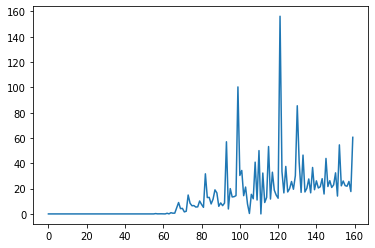

In [6]:
data.new_recovered_per_million.plot()

# CNN model


In [7]:
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 1:]
model_data =  model_data.apply(lambda x :np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0
n_countries = data.location.nunique()
target_data = model_data.new_cases_per_million
# y_naive_copy = target_data.values.copy()

# model_generator = Conv1D_model
time_index = data.time_index

frame_size = 28
start_date = 2*frame_size#+time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [8]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)
(X_cnn_train, y_train, X_cnn_validate, y_validate, X_cnn_test, y_test) = splits
# if need to supply folds for sklearn CV regression functions. 
(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 28 55
Ending with frame ranging time_index values: 131 158


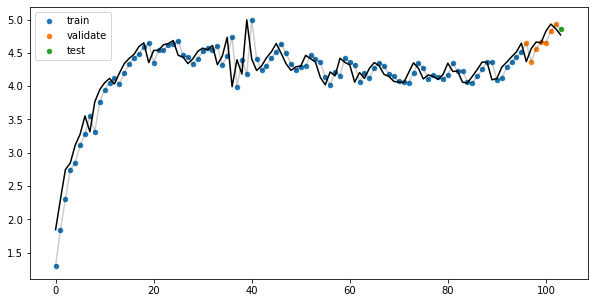

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(range(len(X)), X[:, 0, -1, new_cases_index], s=40, color='r')
ax.scatter(range(len(X_cnn_train)), X_cnn_train[:,0,-1,new_cases_index], s=20, label='train')
ax.scatter(range(len(X_cnn_train), len(X_cnn_train)+len(X_cnn_validate)), X_cnn_validate[:,0,-1,new_cases_index], s=20, label='validate')
ax.scatter(range(len(X_cnn_train)+len(X_cnn_validate), len(X)), X_cnn_test[:,0,-1,new_cases_index], s=20, label='test')
ax.plot(np.log(data.new_cases_per_million.values[start_date-1:-1]+1), color='k', alpha=0.2)
ax.plot(y, color='k')
plt.legend()
_ = plt.show()

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

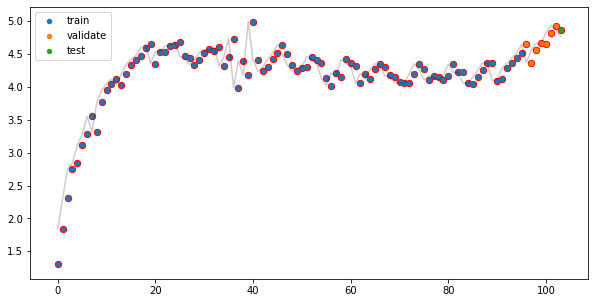

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X)), X[:, 0, -1, new_cases_index], s=40, color='r')
ax.scatter(range(len(X_cnn_train)), X_cnn_train[:,0,-1,new_cases_index], s=20, label='train')
ax.scatter(range(len(X_cnn_train), len(X_cnn_train)+len(X_cnn_validate)), X_cnn_validate[:,0,-1,new_cases_index], s=20, label='validate')
ax.scatter(range(len(X_cnn_train)+len(X_cnn_validate), len(X)), X_cnn_test[:,0,-1,new_cases_index], s=20, label='test')
ax.plot(np.log(data.new_cases_per_million.values[start_date:]+1), color='k', alpha=0.2)
plt.legend()
_ = plt.show()

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

# test on unscaled data

In [11]:
# because only 1 feature, need an extra axis
X_cnn_train_model = np.concatenate(X_cnn_train.reshape(X_cnn_train.shape[0], X_cnn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_validate_model = np.concatenate(X_cnn_validate.reshape(X_cnn_validate.shape[0], X_cnn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_test_model = np.concatenate(X_cnn_test.reshape(X_cnn_test.shape[0], X_cnn_test.shape[1], -1), axis=0)[:,:,np.newaxis]

y_train_cnn_model = y_train.ravel()
y_validate_cnn_model = y_validate.ravel()
y_test_cnn_model = y_test.ravel()

# This is what happens on first run.

In [12]:
epochs = 1000
batch_size = 8
learning_rate = 0.01
kernel = 4
N = 8
FC = 8

f1, f2 = 64, 8
k1, k2 = 4, 4

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
#                  activation='relu'
                )
         )
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Activation('relu'))

cnn_model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 activation='relu'
                )
         )
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(cnn_model.output.shape[1], 
                activation='relu'
               )
         )
cnn_model.add(Dense(1, activation='relu'))
cnn_model.compile(loss='mae', optimizer=Adam(learning_rate=learning_rate))
history = cnn_model.fit(X_cnn_train_model, y_train_cnn_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_validate_cnn_model), 
          batch_size=batch_size, verbose=0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


In [20]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 25, 64)            320       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
activation_4 (Activation)    (None, 12, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 9, 8)              2056      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 8)              0         
_________________________________________________________________
activation_5 (Activation)    (None, 4, 8)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)               

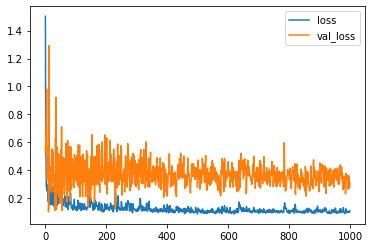

4.994587209674648 4.994587209674648 4.702866
There were 0 negative predictions
1-step MSE [Naive, CNN] = [0.04427888490859516,0.01828480948077341]
1-step R^2 [Naive, CNN] = [0.8054548180396633,0.9222174325681134]


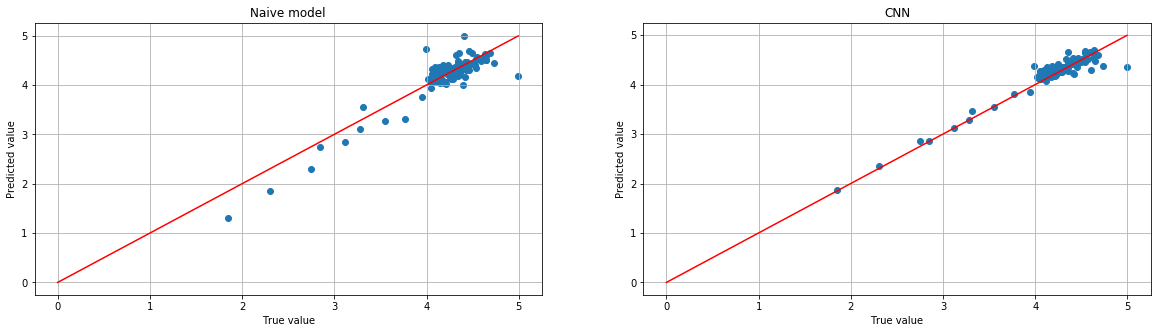

(96,) (96,) (96,)


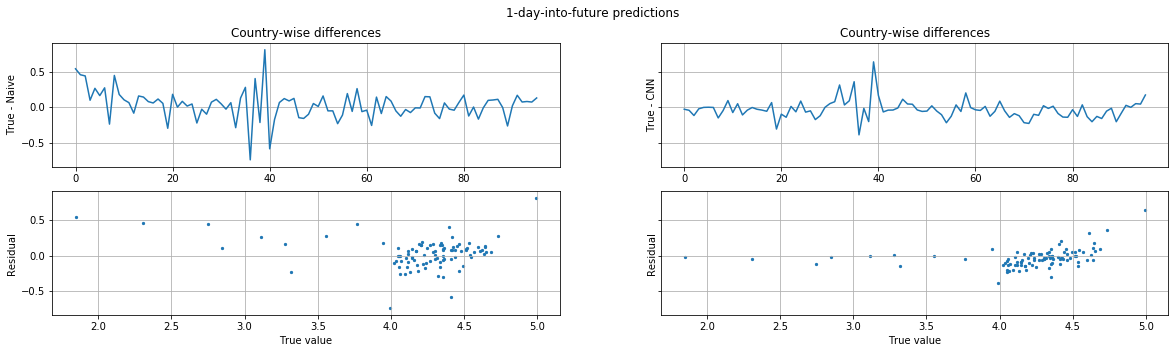

There were 0 negative predictions
1-step MSE [Naive, CNN] = [0.024450914284968067,0.11190264773261818]
1-step R^2 [Naive, CNN] = [0.2789837891641045,0.5395147819791135]


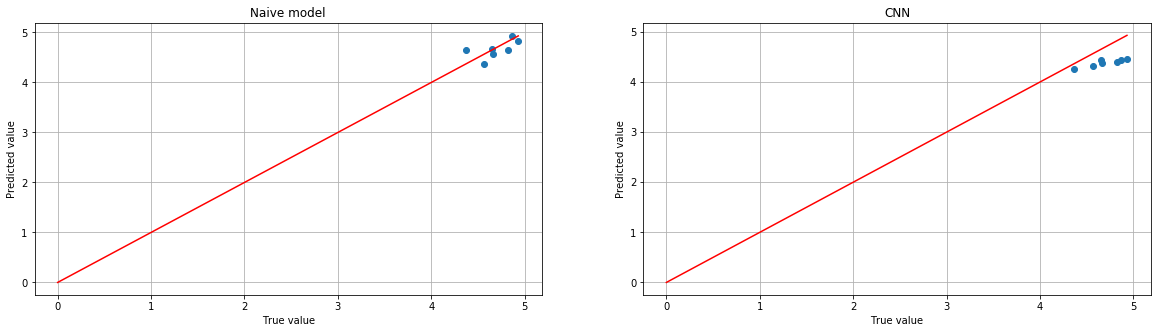

(7,) (7,) (7,)


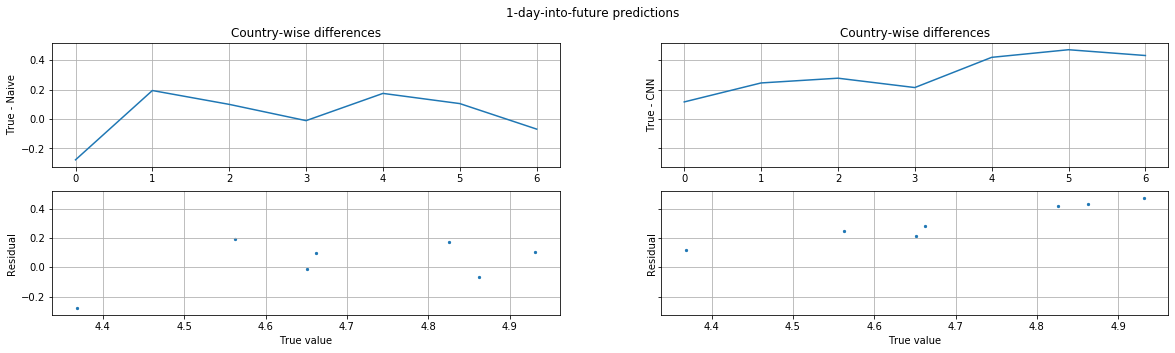

In [13]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

y_true = y_train.ravel()
y_naive = X[:-n_validation_frames-n_test_frames, 0, -1, new_cases_index]
# y_naive = np.exp(X[:-n_validation_frames-n_test_frames, 0, -1, new_cases_index])-1
y_predict = cnn_model.predict(X_cnn_train_model).ravel()
print(y_true.max(),y_naive.max(),y_predict.max())
model_analysis(y_true, y_naive, y_predict, title='CNN')

y_true = y_validate.ravel()
y_naive = X[-n_validation_frames-n_test_frames:-n_test_frames, 0, -1, new_cases_index]
# y_naive = np.exp(X[-n_validation_frames-n_test_frames:-n_test_frames, 0, -1, new_cases_index])-1
y_predict = cnn_model.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_naive, y_predict, title='CNN')

# This is what happens somtimes on first run

# This is what happens on second run

In [16]:
epochs = 1000
batch_size = 8
learning_rate = 0.01
kernel = 4
N = 8
FC = 8

f1, f2 = 64, 8
k1, k2 = 4, 4

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
#                  activation='relu'
                )
         )
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Activation('relu'))

cnn_model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 activation='relu'
                )
         )
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(cnn_model.output.shape[1], 
                activation='relu'
               )
         )
cnn_model.add(Dense(1, activation='relu'))
cnn_model.compile(loss='mae', optimizer=Adam(learning_rate=learning_rate))
history = cnn_model.fit(X_cnn_train_model, y_train_cnn_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_validate_cnn_model), 
          batch_size=batch_size, verbose=0)

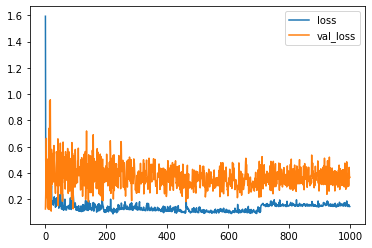

4.994587209674648 4.994587209674648 4.3277216
There were 0 negative predictions
1-step MSE [Naive, CNN] = [0.04427888490859516,0.033707527264128345]
1-step R^2 [Naive, CNN] = [0.8054548180396633,0.84774133239566]


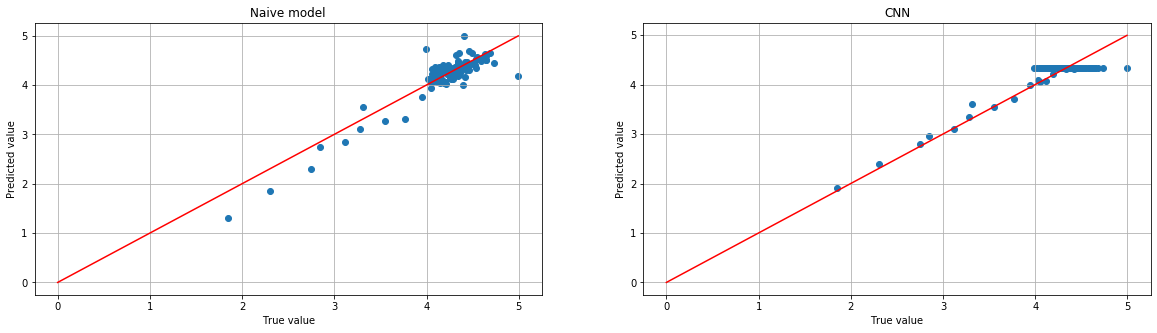

(96,) (96,) (96,)


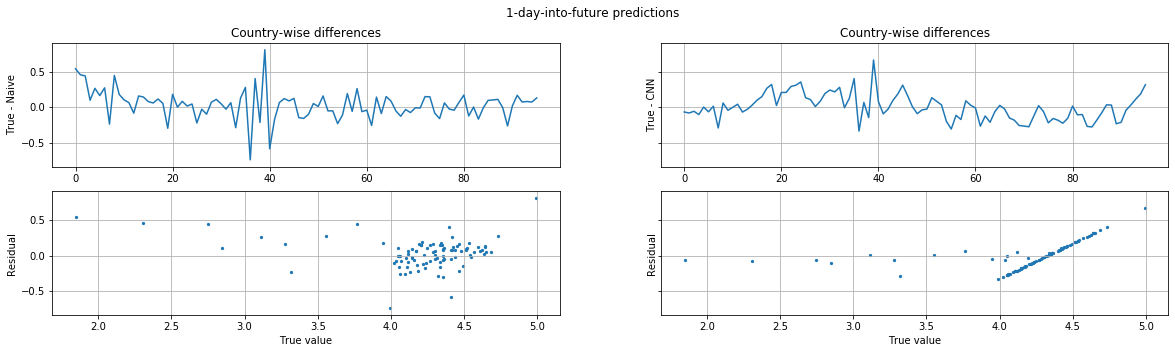

There were 0 negative predictions
1-step MSE [Naive, CNN] = [0.024450914284968067,0.16745695614962683]
1-step R^2 [Naive, CNN] = [0.2789837891641045,2.220446049250313e-16]


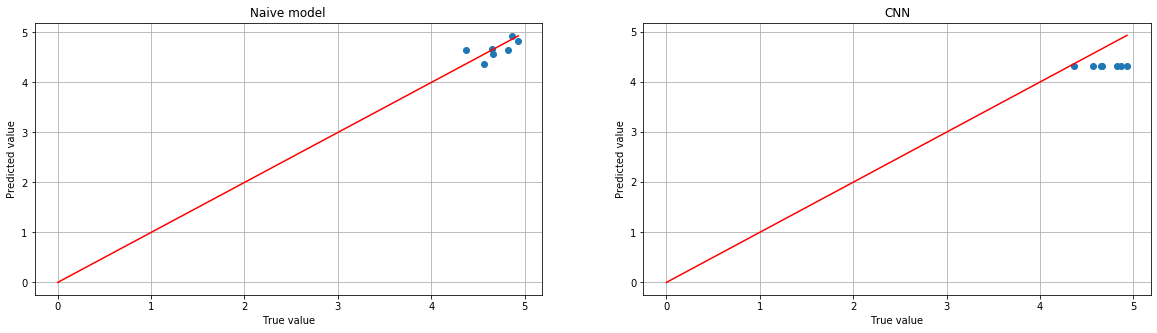

(7,) (7,) (7,)


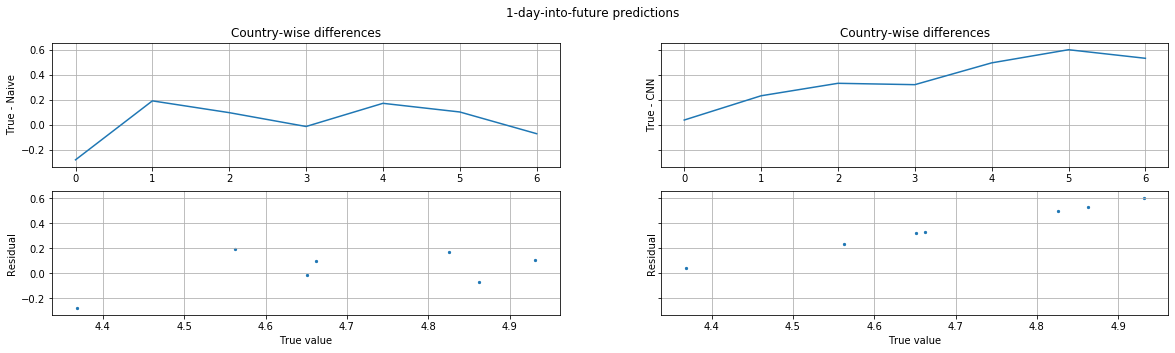

In [17]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

y_true = y_train.ravel()
y_naive = X[:-n_validation_frames-n_test_frames, 0, -1, new_cases_index]
# y_naive = np.exp(X[:-n_validation_frames-n_test_frames, 0, -1, new_cases_index])-1
y_predict = cnn_model.predict(X_cnn_train_model).ravel()
print(y_true.max(),y_naive.max(),y_predict.max())
model_analysis(y_true, y_naive, y_predict, title='CNN')

y_true = y_validate.ravel()
y_naive = X[-n_validation_frames-n_test_frames:-n_test_frames, 0, -1, new_cases_index]
# y_naive = np.exp(X[-n_validation_frames-n_test_frames:-n_test_frames, 0, -1, new_cases_index])-1
y_predict = cnn_model.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_naive, y_predict, title='CNN')

# third run

In [18]:
epochs = 1000
batch_size = 8
learning_rate = 0.01
kernel = 4
N = 8
FC = 8

f1, f2 = 64, 8
k1, k2 = 4, 4

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
#                  activation='relu'
                )
         )
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Activation('relu'))

cnn_model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 activation='relu'
                )
         )
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(cnn_model.output.shape[1], 
                activation='relu'
               )
         )
cnn_model.add(Dense(1, activation='relu'))
cnn_model.compile(loss='mae', optimizer=Adam(learning_rate=learning_rate))
history = cnn_model.fit(X_cnn_train_model, y_train_cnn_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_validate_cnn_model), 
          batch_size=batch_size, verbose=0)

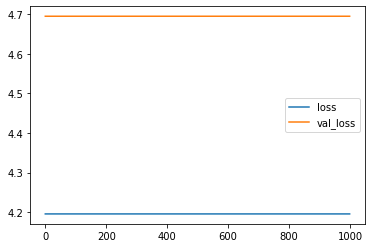

4.994587209674648 4.994587209674648 0.0
There were 0 negative predictions
1-step MSE [Naive, CNN] = [0.04427888490859516,17.82522060131554]
1-step R^2 [Naive, CNN] = [0.8054548180396633,0.0]


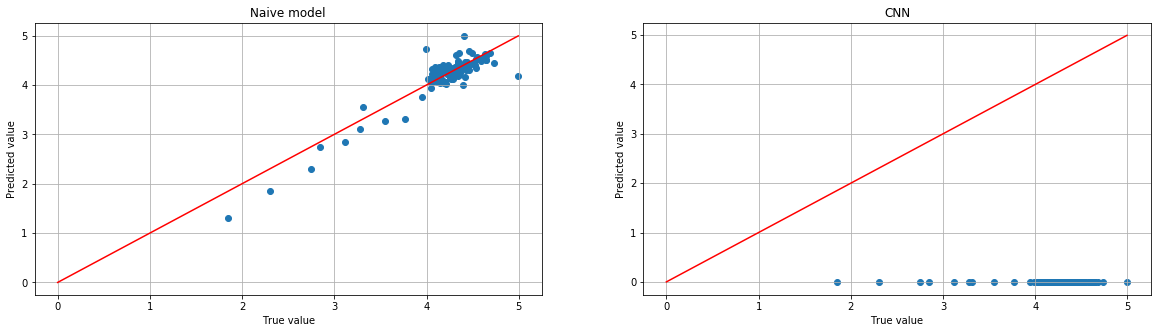

(96,) (96,) (96,)


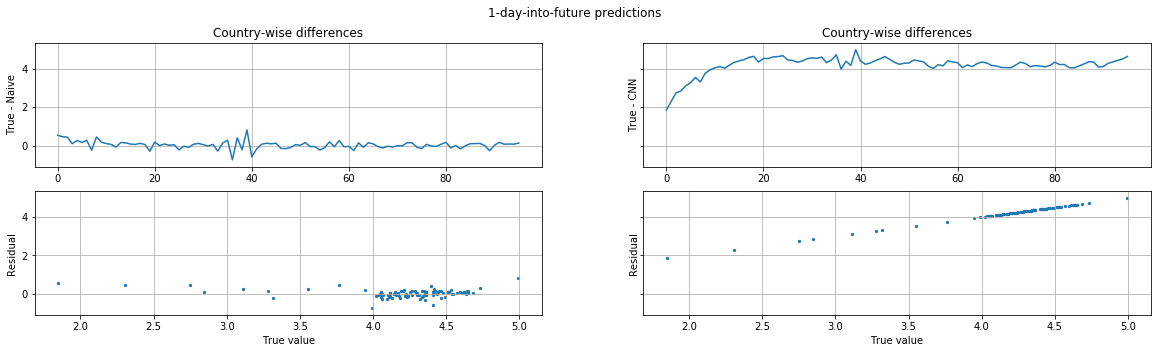

There were 0 negative predictions
1-step MSE [Naive, CNN] = [0.024450914284968067,22.075304359085063]
1-step R^2 [Naive, CNN] = [0.2789837891641045,0.0]


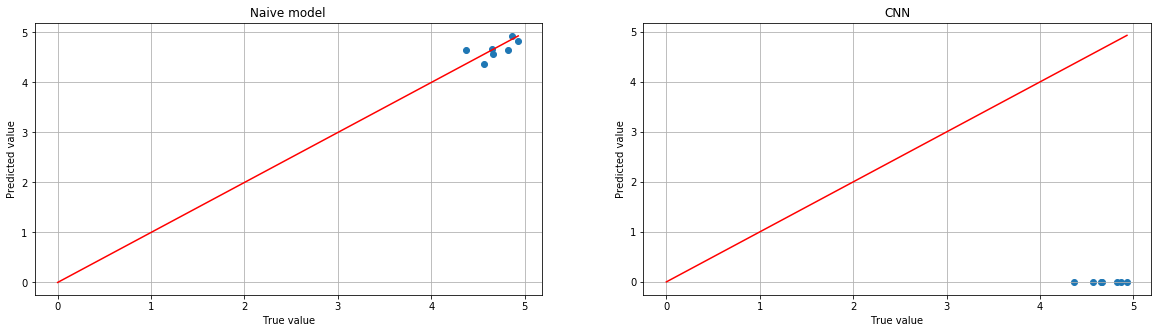

(7,) (7,) (7,)


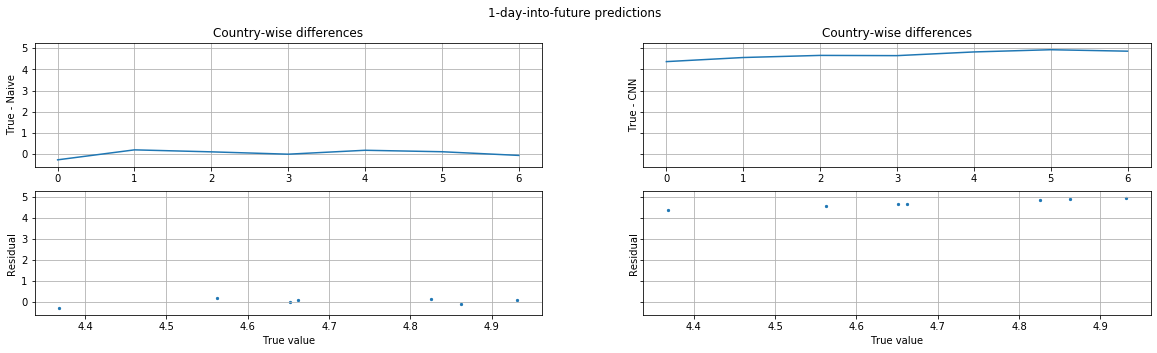

In [19]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

y_true = y_train.ravel()
y_naive = X[:-n_validation_frames-n_test_frames, 0, -1, new_cases_index]
# y_naive = np.exp(X[:-n_validation_frames-n_test_frames, 0, -1, new_cases_index])-1
y_predict = cnn_model.predict(X_cnn_train_model).ravel()
print(y_true.max(),y_naive.max(),y_predict.max())
model_analysis(y_true, y_naive, y_predict, title='CNN')

y_true = y_validate.ravel()
y_naive = X[-n_validation_frames-n_test_frames:-n_test_frames, 0, -1, new_cases_index]
# y_naive = np.exp(X[-n_validation_frames-n_test_frames:-n_test_frames, 0, -1, new_cases_index])-1
y_predict = cnn_model.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_naive, y_predict, title='CNN')

Time index to X relationship.

    Last frame, last day of X is time_index() - n_days_into_future
    last frame, first day is time_index() - n_days_into_future - frame_size
    first frame, first day is start_date-frame_size
    first frame, last day is start_date


In [ ]:
y[:-1]-X[1:,:,-1,0]

In [ ]:
scaled_splits =  normalize_Xy_splits(splits, feature_range=(0,0.5), normalization_method='minmax', train_test_only=False, feature_indices=None)
(X_cnn_train_scaled, y_train, X_cnn_validate_scaled, y_validate, X_cnn_test_scaled, y_test) =scaled_splits

In [ ]:
plt.plot(X_cnn_train[:,-1,0])

In [ ]:
plt.plot(X_cnn_train_scaled[:,-1,0])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(range(len(X)), X[:, 0, -1, new_cases_index], s=40, color='r')
ax.scatter(range(len(X_cnn_train_scaled)), X_cnn_train_scaled[:,0,-1,new_cases_index], s=20, label='train_scaled')
ax.scatter(range(len(X_cnn_train_scaled), len(X_cnn_train_scaled)+len(X_cnn_validate_scaled)), X_cnn_validate_scaled[:,0,-1,new_cases_index], s=20, label='validate_scaled')
ax.scatter(range(len(X_cnn_train_scaled)+len(X_cnn_validate_scaled), len(X)), X_cnn_test_scaled[:,0,-1,new_cases_index], s=20, label='test_scaled')
# ax.plot(np.log(data.new_cases_per_million.values[start_date:]+1), color='k', alpha=0.2)
plt.legend()
_ = plt.show()

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

In [ ]:
X_cnn_train_model = np.concatenate(
    X_cnn_train_scaled.reshape(X_cnn_train_scaled.shape[0],
                           X_cnn_train_scaled.shape[1],
                           -1), axis=0)[:,:,np.newaxis]
X_cnn_test_model = np.concatenate(
    X_cnn_test_scaled.reshape(X_cnn_test_scaled.shape[0],
                          X_cnn_test_scaled.shape[1],
                          -1), axis=0)[:,:,np.newaxis]
X_cnn_validate_model = np.concatenate(
    X_cnn_validate_scaled.reshape(X_cnn_validate_scaled.shape[0],
                             X_cnn_validate_scaled.shape[1],
                             -1), axis=0)[:,:,np.newaxis]


y_cnn_validate_model = y_cnn_validate.ravel()
y_cnn_train_model = y_cnn_train.ravel()
y_cnn_test_model = y_cnn_test.ravel()

epochs = 1000
batch_size = 8
learning_rate = 0.01
kernel = 4
N = 8
FC = 8

f1, f2 = 64, 8
k1, k2 = 4, 4

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 activation='relu'
                )
         )
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Activation('relu'))

cnn_model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 activation='relu'
                )
         )
# cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Activation('relu'))
# cnn_model.add(Flatten())
cnn_model.add(Dense(cnn_model.output.shape[1], 
                activation='relu'
               )
         )
cnn_model.add(Dense(1, activation='relu'))


cnn_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

In [ ]:
cnn_model.summary()

In [ ]:
# np.concatenate(X.reshape(-1, *X.shape[1:]), axis=0)[0,-1,0]
# time_slice(data.iloc[:,1:], start_date,start_date+frame_size).apply(lambda x: np.log(x+1))
# np.concatenate(X.reshape(-1, *X.shape[1:]), axis=0)[-1,-5:,0]

In [ ]:
# np.concatenate(X_train.reshape(-1, *X_train.shape[1:]), axis=0).shape
# np.concatenate(X_train.reshape(-1, *X_train.shape[1:]), axis=0)[-1,-1,0]
# np.concatenate(X.reshape(-1, *X.shape[1:]), axis=0)[-9,-1,0]

In [ ]:
# y_train[-5:]
# data.new_cases_per_million.apply(lambda x: np.log(x+1))[-10:]

In [ ]:
# y_true = y_validate.ravel()
# y_naive = X[-n_validation_frames-n_test_frames:-n_test_frames, 0, -1, new_cases_index]
# y_predict = model.predict(X_validate).ravel()

In [ ]:
# print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
# y_predict[y_predict<0]=0


# mae_train_naive = mean_absolute_error(y_true.ravel(), y_naive.ravel())
# mae_predict = mean_absolute_error(y_true.ravel(), y_predict)
# r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
# r2_predict = explained_variance_score(y_true.ravel(), y_predict)

# print('{}-step MSE [Naive, CNN] = [{},{}]'.format(
# n_days_into_future, mae_train_naive, mae_predict))
# print('{}-step R^2 [Naive, CNN] = [{},{}]'.format(
# n_days_into_future, r2_train_naive, r2_predict))

# true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title='CNN model')
# residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())

In [ ]:
# mae_naive = mean_squared_error(y_validate, y_naive)
# mae_predict = mean_squared_error(y_validate, y_predict)
# r2_naive = explained_variance_score(y_validate, y_naive)
# r2_predict = explained_variance_score(y_validate, y_predict)

# print('{}-step MSE [Naive, CNN] = [{},{}]'.format(
# n_days_into_future, mae_naive, mae_predict))
# print('{}-step R^2 [Naive, CNN] = [{},{}]'.format(
# n_days_into_future, r2_naive, r2_predict))

In [ ]:
# true_predict_plot(y_validate, y_naive, y_predict, title='')
# residual_diff_plots(y_validate.ravel(),y_naive, y_predict, n_days_into_future, n_countries)

Scatter plots of train, validate, test sets, by plotting all values in black first I can ensure that the points
are correctly ordered and at the correct values because it makes the rest of the points look like they have black borders.
The "missing" data point at the end is because it is in the prediction variable y, and not in X.

At first the following plot looks wrong because y looks like it is 1-day behind but this is only because I am
not providing the time values. I.e. the 5th value of y is actually the 6th value of X. 

In [ ]:
plt.plot(X[-30:,0,-1,:], label='x')
plt.plot(y[-30:], label='y')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X)), X[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(X_train)), X_train[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(X_train), len(X_train)+len(X_validate)), X_validate[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(X_train)+len(X_validate), len(X)), X_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='test')
ax.plot(data[data.location=='United States'].new_cases_per_million.values[frame_size-1:-1], color='k',alpha=0.2)
plt.legend()
_ = plt.show()
# plt.plot(X_validate[:,0,-1,:])

In [ ]:
rdata = pd.read_csv('regression_data.csv', index_col=0)

# Regression


# single feature regression

# only new cases

In [ ]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[data.time_index >= first_day]
model_data = data.new_cases_per_million.to_frame().copy()#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index
frame_size = 14
start_date = frame_size-1 #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [ ]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)
(X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
(train_indices, validate_indices, test_indices) = indices

X_regression = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)[:-1,:]
y_regression = y.ravel()[:-1]

In [ ]:
X_regression.shape

In [ ]:
# X_train_regression_model = np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
# X_test_regression_model = np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
# X_validate_regression_model = np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
# y_validate_regression_model = y_validate.ravel()
# y_train_regression_model = y_train.ravel()
# y_test_regression_model = y_test.ravel()

This transformation (slicing off last row) is because X_regression is both training and validation
data to be sliced by the train, validation indices passed to Ridge CV. i.e. the holdout set is being held out.

In [ ]:
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
X_regression[train_indices, last_day_new_cases_index]-X_train[:, :, -1, new_cases_index].ravel()
X[train_indices,0,-1,new_cases_index]-X_train[:, :, -1, new_cases_index].ravel()

# unscaled train predictions; single feature

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

In [ ]:
y_true = y_train_regression_model
y_naive =  X_regression[train_indices, last_day_new_cases_index]
_, y_predict, mse = classifier_analysis(regression_model, X_train_regression_model, 
                                             y_train_regression_model.ravel(), 
                                             plot=False, metric='mse')

print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
y_predict[y_predict<0]=0


mae_train_naive = mean_absolute_error(y_true.ravel(), y_naive.ravel())
mae_predict = mean_absolute_error(y_true.ravel(), y_predict)
r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
r2_predict = explained_variance_score(y_true.ravel(), y_predict)

print('{}-step MSE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_train_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_train_naive, r2_predict))

true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict,s=50)

# unscaled validate predictions; single feature

In [ ]:
y_true = y_validate_regression_model
y_naive =  X_regression[validate_indices, last_day_new_cases_index]
_, y_predict, mse = classifier_analysis(regression_model, X_validate_regression_model, 
                                             y_validate_regression_model.ravel(), 
                                             plot=False, metric='mse')
model_analysis(y_true, y_naive, y_predict, title='CNN')

# print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
# y_predict[y_predict<0]=0


# mae_train_naive = mean_absolute_error(y_true.ravel(), y_naive.ravel())
# mae_predict = mean_absolute_error(y_true.ravel(), y_predict)
# r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
# r2_predict = explained_variance_score(y_true.ravel(), y_predict)

# print('{}-step MSE [Naive, Ridge Regression] = [{},{}]'.format(
# n_days_into_future, mae_train_naive, mae_predict))
# print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
# n_days_into_future, r2_train_naive, r2_predict))

# true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict)
# residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())

In [ ]:
# for i in range(1, X_train.shape[0]+1):
#     # find the minima and maxima of all features for all countries, ranging up to current frame and 
#     # each time step in the frame. 
#     up_to_current_frame_min = X_train[:i,:,:,:].min((0,1,2))
#     up_to_current_frame_max = X_train[:i,:,:,:].max((0,1,2))
#     latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, np.newaxis, np.newaxis, :],(1,1,frame_size,1))
#     latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, np.newaxis, np.newaxis, :],(1,1,frame_size,1))
#     if i == 1:
#         frame_min_array = latest_min_array
#         frame_max_array = latest_max_array
#     else:

#         frame_min_array = np.concatenate((frame_min_array, 
#                                                latest_min_array)
#                                               ,axis=0)
#         frame_max_array = np.concatenate((frame_max_array, 
#                                                latest_max_array)
#                                               ,axis=0)
        

# frame_minmax_denominator = (frame_max_array-frame_min_array)
# num_zeros_train = (frame_minmax_denominator==0).sum()

# frame_minmax_denominator[np.where(frame_minmax_denominator==0)]=1
# X_train = 0.5*(X_train - frame_min_array) / frame_minmax_denominator
# # Use the latest min and max for test scaling.

# frame_denom_for_test = latest_max_array - latest_min_array
# num_zeros_test = (frame_denom_for_test==0).sum()

# frame_denom_for_test[np.where(frame_denom_for_test==0)] = 1

# X_validate = 0.5*(X_validate - latest_min_array) / frame_denom_for_test
# X_test = 0.5*(X_test - latest_min_array) / frame_denom_for_test

# # Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

# scaled single feature

In [ ]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[data.time_index >= first_day]
model_data = data.new_cases_per_million.to_frame().copy()#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index
frame_size = 14
start_date = frame_size-1 #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)
(X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
(train_indices, validate_indices, test_indices) = indices

scaled_splits =  normalize_Xy_splits(splits, feature_range=(0,0.5),
                                     normalization_method='minmax',
                                     train_test_only=False,
                                     feature_indices=None)

(X_train, y_train, X_validate, y_validate, X_test, y_test) = scaled_splits

X_train_regression_model = np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
X_test_regression_model = np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
X_validate_regression_model = np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
y_validate_regression_model = y_validate.ravel()
y_train_regression_model = y_train.ravel()
y_test_regression_model = y_test.ravel()

X_regression = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)[:-1,:]
X_regression = np.concatenate((X_train_regression_model, X_validate_regression_model),axis=0)
y_regression = y.ravel()[:-1]

n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
# X_regression[train_indices, last_day_new_cases_index]-X_train[:, :, -1, new_cases_index].ravel()
# X[train_indices,0,-1,new_cases_index]-X_train[:, :, -1, new_cases_index].ravel()

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

In [ ]:
y_true = y_validate_regression_model.ravel()
y_naive = X[-n_validation_frames-n_test_frames:-n_test_frames, 0, -1, new_cases_index]
y_predict = regression_model.predict(X_validate_regression_model).ravel()

In [ ]:
mean_squared_error(y_true, y_predict)

In [ ]:
model_analysis(y_true, y_naive, y_predict, title='Ridge')

# "All" feature prediction

In [ ]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[data.time_index >= first_day]
regression_model_data = data.iloc[:, 1:].copy()#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(regression_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index
frame_size = 14
start_date = frame_size-1 #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

# Final predictions for comparison

In [ ]:
y_naive = X_test
y_true = y_test
y_predict_r = regression_model.predict(X_test)
y_predict_c = cnn_model.predict(X_test)

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
# for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 1):
#     # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
#     frame_data = model_data[(time_index <= max_date_in_window) & 
#                             (time_index > max_date_in_window-frame_size)]
#     #     print(frame_data.shape)
#     # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
#     reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#     #     print(reshaped_frame_data.shape)
#     # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
#     # the first axis is always the default iteration axis. 
#     # *********************** WARNING: pad_sequences converts to integers by default *********************
#     resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
#     frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
#     if max_date_in_window == start_date:
#         X = frame_data_4D.copy()
#     else:
#         X = np.concatenate((X, frame_data_4D),axis=0)

        
# y = target_data.values[-X.shape[0]:].reshape(-1,1)
# y_time_index = time_index.values[-X.shape[0]:].reshape(-1,1)
# # y = target_data.values.transpose()[-X.shape[0]:,:]
# # y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:]

# y_train =  y[:-(n_validation_frames+n_test_frames),:]
# y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
# X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
# y_train =  y[:-(n_validation_frames+n_test_frames),:]
# X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
# y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
# X_test = X[-n_test_frames:, :, :, :] 
# y_test = y[-n_test_frames:, :]
# splits =  (X_train, y_train, X_validate, y_validate,
#            X_test, y_test)

# y_train_time = y_time_index[:-(n_validation_frames+n_test_frames),:]
# y_validate_time = y_time_index[-(n_validation_frames+n_test_frames):-n_test_frames, :]
# y_test_time = y_time_index[-n_test_frames:, :]

# Before normalization, plot the splits 

#     # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
#     # of steps to predict in the future, this is only slicing the frames. 
#     if train_test_only:
#         (X_train, y_train, X_test, y_test) = splits
#     else:
#         (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits

# #     if normalization_method=='minmax':
#         # To encapsulate the time-dependent nature of the problem and ignore the dramatic difference between current
#         # and initial behavior, only rescale the validation and testing frames by the most recent frame's values.
#         # There is only a single value per feature in this case, meaning that to rescale, the values need to
#         # be repeated for each validation, test frame for each country for each timestep.
#     X_min = X_train.min(axis=(2))
#     X_max = X_train.max(axis=(2))


#     X_train_scaled = minmax(X_train, X_min[:, :, np.newaxis, :],
#                     X_max[:, :, np.newaxis, :])
#     X_test_scaled = minmax(X_test, X_min[-1][np.newaxis, :, np.newaxis, :], 
#                            X_max[-1][np.newaxis, :, np.newaxis, :])
#     if train_test_only:
#     # Normalize the training data by each frame's specific mean and std deviation. 
#         splits = (X_train_scaled, y_train, X_test_scaled, y_test)
#     else:
#         X_validate_scaled = minmax(X_validate, X_min[-1,:][np.newaxis, :, np.newaxis, :], 
#                                    X_max[-1,:][np.newaxis, :, np.newaxis, :])
#         splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)


In [ ]:
# for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
#     # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
#     frame_data = model_data[(time_index <= max_date_in_window - 1) & 
#                             (time_index >= max_date_in_window-frame_size)]
#     #     print(frame_data.shape)
#     # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
#     reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#     #     print(reshaped_frame_data.shape)
#     # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
#     # the first axis is always the default iteration axis. 
#     # *********************** WARNING: pad_sequences converts to integers by default *********************
#     resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
#     frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
# #     break
#     if max_date_in_window == start_date:
#         print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)

#         X = frame_data_4D.copy()
#     else:
#         X = np.concatenate((X, frame_data_4D),axis=0)
# print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
# y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
